In [7]:
from glob import glob 
from pathlib import Path
import polars as pl
import re
import os

def extract_info_from_filename(filename):
    pattern = r"([a-zA-Z_]+)_cov_(0\.\d)_iden_(0\.\d)\.txt"
    match = re.match(pattern, filename)
    if match:
        category = match.group(1)
        coverage = float(match.group(2))
        identity = float(match.group(3))
        return category, coverage, identity
    return None

descriptors_dir = glob("database/descriptors/*")

dfs = {}

for path in descriptors_dir: 

    category = Path(path).stem
    dfs[category] = pl.read_parquet(path)


directory = './database/representatives' 


data = {}

for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        filepath = os.path.join(directory, filename)
        
        # Extract information from the filename
        info = extract_info_from_filename(filename)
        if info:
            category, coverage, identity = info
            
            # Read the file and collect ids
            with open(filepath) as f:
                ids = [line.strip() for line in f.readlines()]
            
            # Populate the nested dictionary
            if category not in data:
                data[category] = {}
            
            if coverage not in data[category]:
                data[category][coverage] = {}
            
            data[category][coverage][identity] = ids

result = []

for category, coverages in data.items():
    
    for coverage, identities in coverages.items():
            
        for identity, ids in identities.items():

            if coverage == 0.7 and identity == 0.3: 

                buff_df = (dfs[category]
                            .filter(pl.col("id").is_in(ids))
                            .with_columns(
                                category = pl.lit(category)
                            )
                        ).sample(n=500, with_replacement=True)
                
                result.append(buff_df)
                
final_data = pl.concat(result, how = "vertical")
                


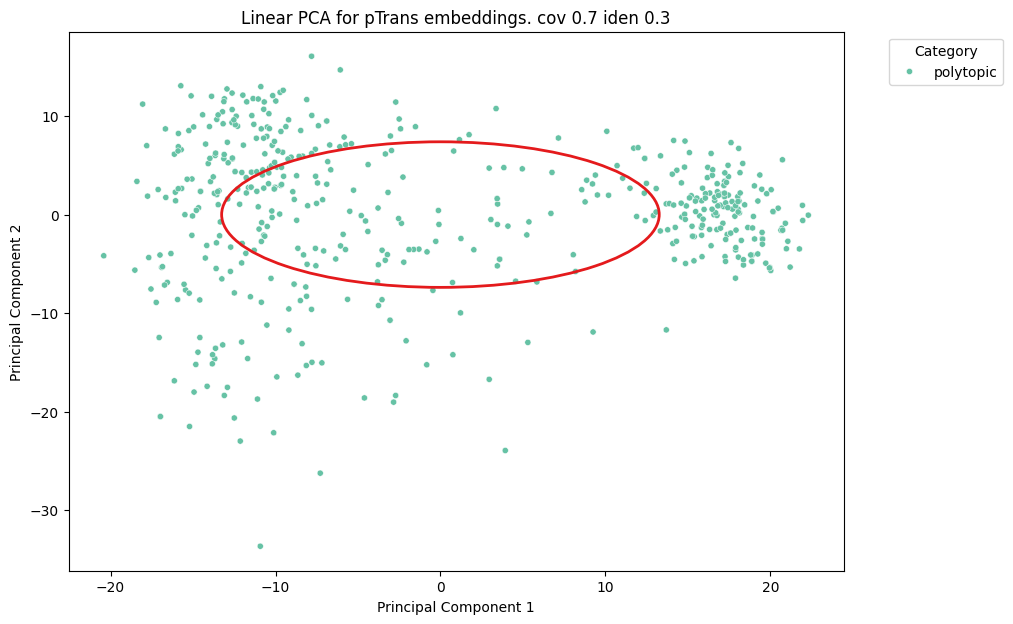

In [10]:
import polars as pl
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse

# Your list of sequence descriptors
sequence_descriptors = [
    
    'hydrophobic_portion', 'iupred_portion', 'iupred_mean', 'anchor_portion', 
    'HCA_score', 'A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 
    'F', 'P', 'S', 'T', 'W', 'Y', 'V', 'ARGP820103', 'BHAR880101', 'CHAM810101', 
    'CHAM820101', 'CHAM830101', 'CHAM830107', 'CHAM830108', 'CHOP780201', 'CHOP780202', 
    'CHOP780203', 'CIDH920105', 'FASG760101', 'FAUJ880102', 'FAUJ880103', 'FAUJ880104', 
    'FAUJ880105', 'FAUJ880106', 'FAUJ880109', 'FAUJ880110', 'FAUJ880111', 'FAUJ880112', 
    'FAUJ880113', 'GRAR740102', 'JANJ780102', 'JANJ780103', 'JOND920102', 'JUNJ780101', 
    'KLEP840101', 'KRIW790101', 'KYTJ820101', 'LEVM760102', 'LEVM760103', 'LEVM760104', 
    'LEVM760105', 'LEVM760106', 'LEVM760107', 'NISK800101', 'NISK860101', 'PONP800101', 
    'RACS770103', 'RADA880108', 'ROSG850101', 'ROSG850102', 'ROSM880102', 'WARP780101', 
    'WOLR810101', 'VINM940101', 'TAKK010101', 'MONM990201', 'KOEP990101', 'KOEP990102', 
    'MITS020101', 'COSI940101', 'PONP930101', 'ZHOH040102', 'ZHOH040103', 'BAEK050101', 
    'CASG920101'

]

category_to_choose = ["polytopic"]

# Your DataFrame and filtering
df = final_data.select(pl.exclude(sequence_descriptors)).filter(pl.col("category").is_in(category_to_choose))

# Convert Polars DataFrame to Pandas for PCA
df_pd = df.to_pandas()

# Selecting only numeric columns
numeric_columns = df_pd.select_dtypes(include=[np.number]).columns
X = df_pd[numeric_columns].values

# Extract categories
categories = df_pd['category']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a Pandas DataFrame for the PCA results
pca_df = pl.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'category': categories
})

# Convert back to Pandas for Seaborn plotting
pca_df_pd = pca_df.to_pandas()

palette = sns.color_palette('Set1', n_colors=len(pca_df_pd['category'].unique()))

# Create a mapping of categories to colors
category_colors = dict(zip(pca_df_pd['category'].unique(), palette))

# Function to create an ellipse for each category with specific color

def draw_ellipse(ax, x_data, y_data, color):

    cov = np.cov(x_data, y_data)
    mean = [np.mean(x_data), np.mean(y_data)]
    
    # Eigenvalues and eigenvectors
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    
    # Calculate angle and width/height of ellipse
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigvals)
    
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, 
                      edgecolor=color, fc='None', lw=2)
    ax.add_patch(ellipse)

# Plot the PCA components, colored by category
plt.figure(figsize=(10, 7))
ax = sns.scatterplot(x='PC1', y='PC2', hue='category', data=pca_df_pd, palette='Set2', s=20)

# Draw ellipses for each category with the corresponding color
for category in pca_df_pd['category'].unique():

    subset = pca_df_pd[pca_df_pd['category'] == category]

    draw_ellipse(ax, subset['PC1'], subset['PC2'], color=category_colors[category])

# Add plot labels and title
plt.title('Linear PCA for pTrans embeddings. cov 0.7 iden 0.3')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

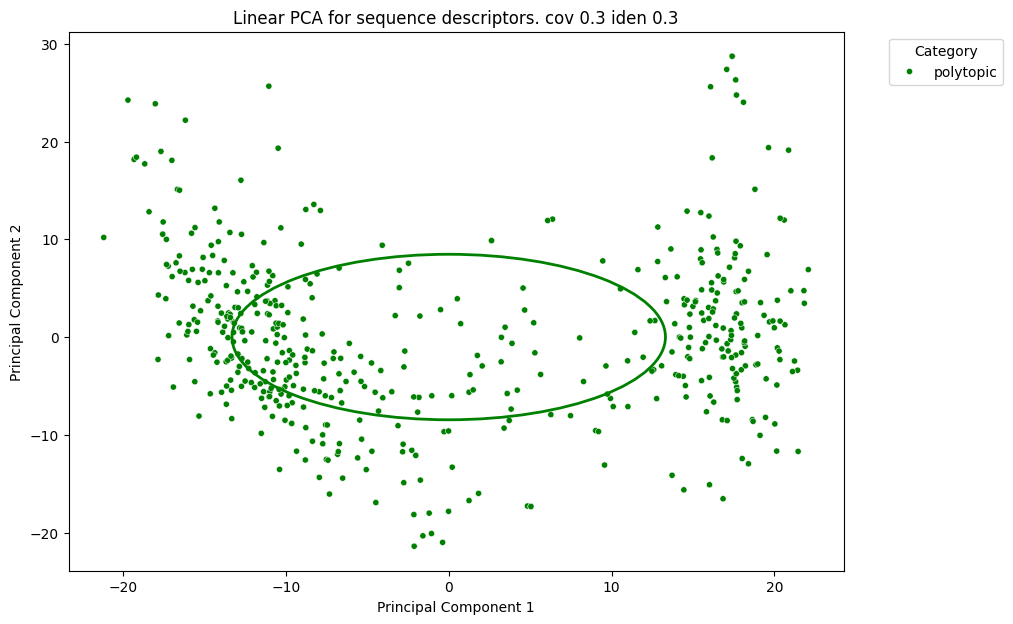

In [9]:
import polars as pl
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse

# Your list of sequence descriptors
sequence_descriptors = [
    
    'hydrophobic_portion', 'iupred_portion', 'iupred_mean', 'anchor_portion', 
    'HCA_score', 'A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 
    'F', 'P', 'S', 'T', 'W', 'Y', 'V', 'ARGP820103', 'BHAR880101', 'CHAM810101', 
    'CHAM820101', 'CHAM830101', 'CHAM830107', 'CHAM830108', 'CHOP780201', 'CHOP780202', 
    'CHOP780203', 'CIDH920105', 'FASG760101', 'FAUJ880102', 'FAUJ880103', 'FAUJ880104', 
    'FAUJ880105', 'FAUJ880106', 'FAUJ880109', 'FAUJ880110', 'FAUJ880111', 'FAUJ880112', 
    'FAUJ880113', 'GRAR740102', 'JANJ780102', 'JANJ780103', 'JOND920102', 'JUNJ780101', 
    'KLEP840101', 'KRIW790101', 'KYTJ820101', 'LEVM760102', 'LEVM760103', 'LEVM760104', 
    'LEVM760105', 'LEVM760106', 'LEVM760107', 'NISK800101', 'NISK860101', 'PONP800101', 
    'RACS770103', 'RADA880108', 'ROSG850101', 'ROSG850102', 'ROSM880102', 'WARP780101', 
    'WOLR810101', 'VINM940101', 'TAKK010101', 'MONM990201', 'KOEP990101', 'KOEP990102', 
    'MITS020101', 'COSI940101', 'PONP930101', 'ZHOH040102', 'ZHOH040103', 'BAEK050101', 
    'CASG920101', 'category'
]

# Your DataFrame and filtering
df = final_data.filter(pl.col("category").is_in(["polytopic"]))

# Convert Polars DataFrame to Pandas for PCA
df_pd = df.to_pandas()

# Selecting only numeric columns
numeric_columns = df_pd.select_dtypes(include=[np.number]).columns
X = df_pd[numeric_columns].values

# Extract categories
categories = df_pd['category']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a Pandas DataFrame for the PCA results
pca_df = pl.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'category': categories
})

# Convert back to Pandas for Seaborn plotting
pca_df_pd = pca_df.to_pandas()

palette = sns.color_palette('Set2', n_colors=len(pca_df_pd['category'].unique()))

# Create a mapping of categories to colors
#category_colors = dict(zip(pca_df_pd['category'].unique(), palette))

category_colors = {

    "Structured_solution" : "blue",
    "Small" : "black",
    "peripheral" : "red",
    "polytopic" : "green", 
    "bitopic" : "green", 
    "horizontal" : "orange", 
    "disprot" : "grey",
    "random_uniform" : "white",
    "random_proportional" : "white"

}

# Function to create an ellipse for each category with specific color
def draw_ellipse(ax, x_data, y_data, color):
    cov = np.cov(x_data, y_data)
    mean = [np.mean(x_data), np.mean(y_data)]
    
    # Eigenvalues and eigenvectors
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    
    # Calculate angle and width/height of ellipse
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigvals)
    
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, 
                      edgecolor=color, fc='None', lw=2)
    ax.add_patch(ellipse)

# Plot the PCA components, colored by category
plt.figure(figsize=(10, 7))
ax = sns.scatterplot(x='PC1', y='PC2', hue='category', data=pca_df_pd, palette=category_colors, s=20)

# Draw ellipses for each category with the corresponding color
for category in pca_df_pd['category'].unique():
    subset = pca_df_pd[pca_df_pd['category'] == category]
    draw_ellipse(ax, subset['PC1'], subset['PC2'], color=category_colors[category])

# Add plot labels and title
plt.title('Linear PCA for sequence descriptors. cov 0.3 iden 0.3')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [1]:
from bin.data.SCOPe import main as SCOPe

results = SCOPe()


Working on the main directory : /Users/simonherman/Documents/I2BC/Peptides
Adding class a
Adding class b
Adding class c
Adding class d
Adding class f
Adding class g


In [4]:
sum([["A"]], ["b"])  # Concatenates two lists successfully


['b', 'A']